In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filePath = "data/ml-100k/u1.base"
with open(filePath, "rt") as dataPath:
    raw_data = dataPath.read().splitlines()
datapoints = [[int(i) for i in data.split("\t")] for data in raw_data]

# indexing on users/movies starts at 1, reset to index from 0, this will be important when we do testing
datapoints = np.array([[row[0], row[1], row[2], row[3]] for row in datapoints])
np.random.shuffle(datapoints)

user_ids = set([datapoint[0] for datapoint in datapoints])
n_users = len(user_ids)
max_user = max(user_ids) + 1
print("n users:", n_users)
items_ids = set([datapoint[1] for datapoint in datapoints])
n_items = len(items_ids)
max_item = max(items_ids) + 1
print("n items:", n_items)

n users: 943
n items: 1650


In [3]:
def softmax(x):
    # subtract max value to prevent overflow\n"
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (np.random.random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, and choose positions with a consistent random offset
    positions = (np.random.random() + np.arange(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [4]:
n_particles = 10
k = 3
var = 0.5
particles = [(1 / n_particles, {"u": np.random.normal(size=(max_user, k)),
                                "v": np.random.normal(size=(max_item, k)),
                                "var_u": 1.0,
                                "var_i": 1.0}) for _ in range(n_particles)]

# get mean rating to make rating data centered at 0
mean_rating = np.mean(datapoints[:, 2])
data_store = {u_id: {row[1]: row[2] - mean_rating for row in datapoints if row[0] == u_id} for u_id in user_ids}

user_history = {} # user_rating_history[user_id]["item_ids"], user_rating_history[user_id]["ratings"]
item_history = {} # item_rating_history[item_id]["user_ids"], item_rating_history[item_id]["ratings"]
ses = []
ctr = 0
ctr_hist = []
uniParticlesList = []
multi, strat, system = [], [], []

# what we're going to do here is assume that OUR system made the item recommendation and is observing the
# rating we have in the dataset ... it's sort of like we're starting at line 11
for _idx in range(len(datapoints)):

    # randomly get a user
    user_id = np.random.choice([i for i in data_store.keys()])
    user_items = [i for i in data_store[user_id].keys()]
    
    # highest rating this user has
    highest_rating = max(data_store[user_id].values())
    # get highest rated items
    highest_rated_items = [x for x in data_store[user_id].keys() if data_store[user_id][x] >= highest_rating]
    
    # get indices for items this user rated
    indices = np.array(user_items)
    
    # randomly select a particle
    random_particle = np.random.choice(range(n_particles))
    particle = particles[random_particle]
    
    # predict a rating only for the items rated by that user
    predicted_rating = np.dot(particle[1]["u"][user_id, :], particle[1]["v"][indices, :].T)
    
    # get the item id
    max_rating_ind = np.argmax(predicted_rating)
    item_id = [i for i in data_store[user_id].keys()][max_rating_ind]
    
    # add to ctr if possible
    if item_id in highest_rated_items:
        ctr += 1
    ctr_hist.append(ctr / (_idx + 1))
    
    # get the true rating
    rating = data_store[user_id][item_id]
    
    # delete this item from this user
    del data_store[user_id][item_id]
    
    # delete the user from the data store if they have no reviews left
    if not data_store[user_id]:
        del data_store[user_id]
        
    error = predicted_rating[max_rating_ind] - rating
    se = error ** 2
    if _idx % 101 == 0:
        ses.append(se)
    if _idx % 1000== 0:
        print("squared error: {:.2f}".format(se))

    # line 17
    precision_u_i = []
    eta_u_i = []
    for particle in particles:
        if user_id not in user_history:
            precision_u_i.append(np.eye(k))
            eta_u_i.append(np.zeros(k))
        else:
            v_j = particle[1]["v"][user_history[user_id]["item_ids"], :]
            lambda_u_i = 1 / var * \
                np.dot(v_j.T, v_j) + \
                1 / particle[1]["var_u"] * np.eye(k)

            precision_u_i.append(lambda_u_i)

            eta = np.sum(
                np.multiply(
                    v_j,
                    np.array(user_history[user_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
            eta_u_i.append(eta.reshape(-1))

    # line 18
    weights = []
    mus = [1 / var * np.dot(np.linalg.inv(lambda_), eta) for lambda_, eta in zip(precision_u_i, eta_u_i)]
    for particle, mu, precision in zip(particles, mus, precision_u_i):
        v_j = particle[1]["v"][item_id, :]
        cov = 1 / var + np.dot(np.dot(v_j.T, precision), v_j)
        w = np.random.normal(
            np.dot(v_j.T, mu),
            cov
        )
        weights.append(w)
    normalized_weights = softmax(weights)

    # line 19
    eff_threshold = 4
    Neff = 1/sum([i**2 for i in normalized_weights])
    #print(Neff)
    #if not all(weight > 1./n_particles for weight in normalized_weights):
    if Neff >= eff_threshold:
        #print("resampling...")
        ds = [np.random.choice(range(n_particles), p=normalized_weights) for _ in range(n_particles)]
        multi.append(len(set(ds)))

        # Capture # of particles. Just test to see what stratfied/systematic resampling gives
        # str_idx
        str_idx = stratified_resample(normalized_weights)
        strat.append(len(set(str_idx)))
        
        # sys_idx
        ds = systematic_resample(normalized_weights)
        system.append(len(set(ds)))
    else:
        ds = [i for i in range(n_particles)]

    p_prime = [{"u": np.copy(particles[d][1]["u"]),
                "v": np.copy(particles[d][1]["v"]),
                "var_u": particles[d][1]["var_u"],
                "var_i": particles[d][1]["var_i"]} for d in ds]
        
    for idx, (particle, precision, e) in enumerate(zip(p_prime, precision_u_i, eta_u_i)):

        # line 21
        v_j = particle["v"][item_id, :]
        add_to_precision = 1 / var * np.dot(v_j.reshape(-1, 1), v_j.reshape(1, -1))
        precision += add_to_precision

        add_to_eta = rating * v_j
        e += add_to_eta

        # line 22
        sampled_user_vector = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision), e),
            np.linalg.inv(precision)
        )
        
        p_prime[idx]["u"][user_id, :] = sampled_user_vector

        # line 24
        if item_id not in item_history:
            precision_v_i = np.eye(k)
            eta = np.zeros(k)
        else:
            u_i = particle["u"][item_history[item_id]["user_ids"], :]
            precision_v_i = 1 / var * \
                np.dot(u_i.T, u_i) + \
                1 / particle["var_i"] * np.eye(k)

            eta = np.sum(
                np.multiply(
                    u_i,
                    np.array(item_history[item_id]["ratings"]).reshape(-1, 1)
                ),
                axis=0
            )
        # line 25
        item_sample = np.random.multivariate_normal(
            1 / var * np.dot(np.linalg.inv(precision_v_i), eta),
            np.linalg.inv(precision_v_i)
        )
        p_prime[idx]["v"][item_id, :] = item_sample
        
    particles = [(1 / n_particles, particle) for particle in p_prime]

    if user_id not in user_history:
        user_history[user_id] = {"item_ids": [], "ratings": []}
    if item_id not in item_history:
        item_history[item_id] = {"user_ids": [], "ratings": []}
    user_history[user_id]["item_ids"].append(item_id)
    user_history[user_id]["ratings"].append(rating)
    item_history[item_id]["user_ids"].append(user_id)
    item_history[item_id]["ratings"].append(rating)

squared error: 1.48
squared error: 24.94
squared error: 3.15
squared error: 19.60
squared error: 8.59
squared error: 0.88
squared error: 26.43
squared error: 0.15
squared error: 0.30
squared error: 0.88
squared error: 1.02
squared error: 11.31
squared error: 0.96
squared error: 0.18
squared error: 0.50
squared error: 2.10
squared error: 0.01
squared error: 0.01
squared error: 1.23
squared error: 0.12
squared error: 0.61
squared error: 0.24
squared error: 1.44
squared error: 9.60
squared error: 1.36
squared error: 5.17
squared error: 1.34
squared error: 1.15
squared error: 0.78
squared error: 0.25
squared error: 0.05
squared error: 0.67
squared error: 0.03
squared error: 0.03
squared error: 0.69
squared error: 7.48
squared error: 0.97
squared error: 0.98
squared error: 0.87
squared error: 0.93
squared error: 0.45
squared error: 0.14
squared error: 3.18
squared error: 4.51
squared error: 3.51
squared error: 0.89
squared error: 2.11
squared error: 0.08
squared error: 5.96
squared error: 0

In [5]:
print("Avg num particles Multinomial:", round(np.mean(multi),2) ) # On average looks like multi uses less particles
print("Avg num particles Stratfied:", round(np.mean(strat),2) ) # Followed slightly by stratefied sampling
print("Avg num particles Systematic:", round(np.mean(system),2) ) # Systematic uses most -- wonder if should change from multi above to systematic?

Avg num particles Multinomial: 4.63
Avg num particles Stratfied: 5.02
Avg num particles Systematic: 5.31


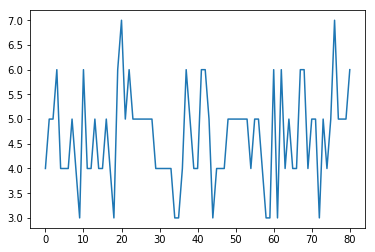

In [6]:
plt.plot(multi)

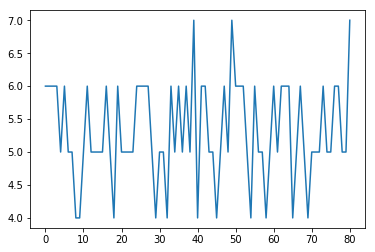

In [7]:
plt.plot(system)

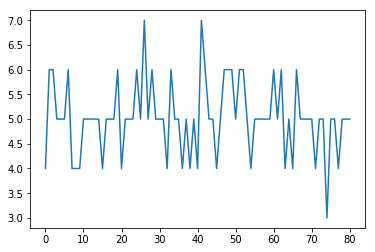

In [8]:
plt.plot(strat)

In [9]:
def average_particles(p_hist, interval=4):
    avg = []
    for i in range(0,len(strat)-1, interval):
        avg.append(sum(strat[i : i + interval])/interval)
    return avg

# Need to make this just a smoothed line graph. Line graph isn't showing same result
def plot_avgParticles(avg, n_particles=n_particles, k=k):
    plt.plot(avg)
    plt.title("Final Particle Number: {:.0f} | Particles Num = {}, K = {}".format(avg[-1], n_particles, k))
    plt.xlabel('resample step')
    plt.show()

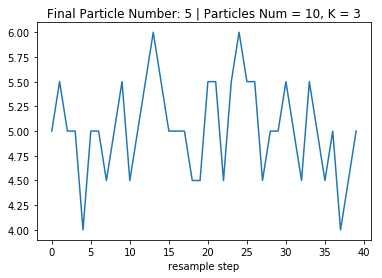

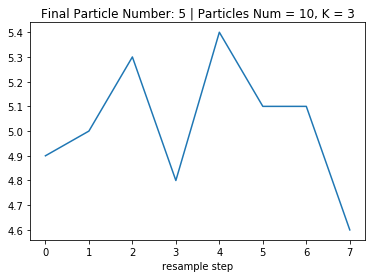

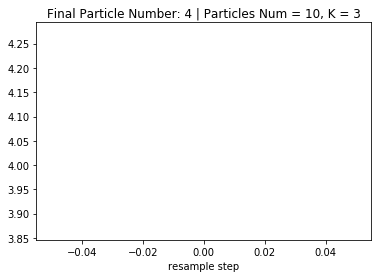

In [10]:
# Plot of multinomial average every 2 iters
# Like how it shows we use ~5 particles then -> 1
avg = average_particles(multi, 2)
plot_avgParticles(avg)

# Plot of stratfied resampling every  10 iters
avg = average_particles(strat, 10)
plot_avgParticles(avg)

# Plot of systematic resampling every  100 iters
# Smooth line but seems like only use ~2 -> 1
avg = average_particles(system, 100)
plot_avgParticles(avg)

In [11]:
def moving_average(x):
    avgs = []
    for i, v in enumerate(x):
        avgs.append(np.sum(x[:i]) / i)
    return avgs

/home/michael/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


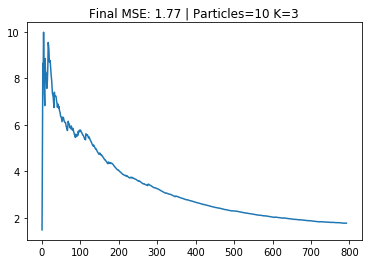

In [12]:
mses = moving_average(ses)
plt.plot(mses)
plt.title("Final MSE: {:.2f} | Particles={} K={}".format(mses[-1], n_particles, k))
plt.show()

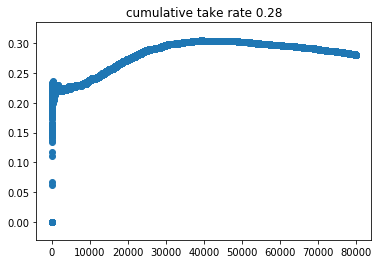

In [13]:
plt.scatter(range(len(ctr_hist)), ctr_hist)
plt.title("cumulative take rate {:.2f}".format(ctr_hist[-1]))
plt.show()